<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 

epoch,train_loss,valid_loss,mae,time
0,0.006606,0.000892,0.025165,00:02
1,0.004511,0.001568,0.036059,00:02
2,0.002930,0.005301,0.062661,00:01
3,0.001452,0.000138,0.007295,00:01
4,0.000898,0.000079,0.007819,00:01
5,0.001183,0.000059,0.006416,00:01
6,0.000746,0.000045,0.005405,00:02
7,0.000743,0.000043,0.006108,00:01
8,0.000653,0.000029,0.004229,00:01
9,0.000834,0.000000,0.000450,00:01


Train MAE: 0.0014
Validation MAE: 0.0004
Test MAE: 0.0004


Inverse-Transformed Predictions range: -1647.9332275390625 to 10120.8828125
Inverse-Transformed Targets range: -1645.0 to 29.933391571044922
Validation RMSE: 5250.0232


Predicted next 4 values: [-1647.9332 -1647.9332 -1647.9332 10102.56  ]


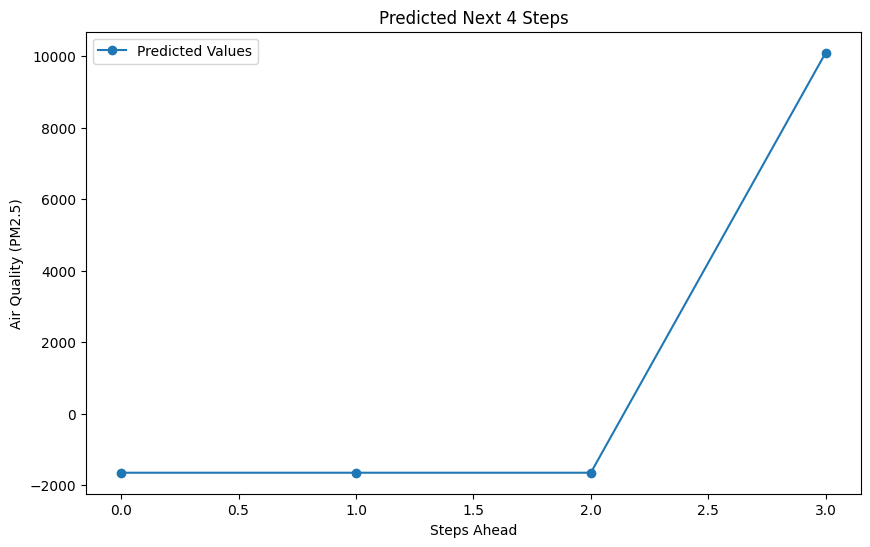

In [ ]:
!pip install tsai
!pip install fastai

import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive
from fastai.callback.tracker import EarlyStoppingCallback

class PatchTST(nn.Module):
    def __init__(self,
                 c_in,
                 c_out,
                 seq_len,
                 pred_dim=None,
                 n_layers=2,
                 n_heads=8,
                 d_model=512,
                 d_ff=2048,
                 dropout=0.05,
                 attn_dropout=0.,
                 patch_len=16,
                 stride=8,
                 padding_patch=True,
                 revin=True,
                 affine=False,
                 individual=False,
                 subtract_last=False,
                 decomposition=False,
                 kernel_size=25,
                 activation="gelu",
                 norm='BatchNorm',
                 pre_norm=False,
                 res_attention=True,
                 store_attn=False,
                 ):
        super().__init__()

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.n_patches = (seq_len // patch_len) + (1 if seq_len % patch_len else 0)

        self.patch_embedding = nn.Linear(patch_len, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.n_patches + 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                                                   dropout=dropout, activation=activation)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.output_layer = nn.Linear(d_model, c_out)

    def forward(self, x):
        batch_size = x.size(0)
        if self.padding_patch:
            if x.shape[-1] % self.patch_len != 0:
                pad_len = self.patch_len - x.shape[-1] % self.patch_len
                x = torch.cat([x, torch.zeros(batch_size, x.shape[1], pad_len, device=x.device)], dim=-1)

        patches = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        patches = patches.reshape(batch_size, patches.shape[1], -1, self.patch_len)
        patches = patches.permute(0, 2, 1, 3)
        patches = patches.reshape(batch_size, patches.shape[1], -1)

        embeddings = self.patch_embedding(patches)
        embeddings = embeddings + self.position_embedding[:, :embeddings.shape[1], :]

        embeddings = embeddings.permute(1, 0, 2)
        encoded_output = self.transformer_encoder(embeddings)

        output = encoded_output[-1]
        output = self.output_layer(output)

        return output

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start', 'End'])

df = df[['Start', 'Value']].sort_values(by='Start')

df.set_index('Start', inplace=True)
df_resampled = df.resample('6H').mean().reset_index()

scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])

values = df_resampled['Value'].values

sequence_length = 4
forecast_steps = 4

X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)

train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)

tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)

model = PatchTST(
    c_in=1,
    c_out=forecast_steps,
    seq_len=sequence_length,
    d_model=128,
    n_heads=8,
    patch_len=16,
    stride=8,
    dropout=0.05,
    attn_dropout=0.0,
    n_layers=2,
    activation="gelu",
    norm="BatchNorm",
)

early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mae, cbs=[early_stop_cb])

learn.fit_one_cycle(10, lr_max=1e-3)

train_mae = learn.validate(ds_idx=0)[1]
valid_mae = learn.validate(ds_idx=1)[1]
test_mae = learn.validate(ds_idx=2)[1]

print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {valid_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

preds, targs = learn.get_preds(ds_idx=1)

y_valid_pred = preds.numpy()
y_valid_true = targs.numpy()

scaled_min, scaled_max = 0.0, 1.0
y_valid_pred = np.clip(y_valid_pred, scaled_min, scaled_max)

y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid_true = scaler.inverse_transform(y_valid_true)

print(f"Inverse-Transformed Predictions range: {y_valid_pred.min()} to {y_valid_pred.max()}")
print(f"Inverse-Transformed Targets range: {y_valid_true.min()} to {y_valid_true.max()}")

rmse = sqrt(mean_squared_error(y_valid_true.flatten(), y_valid_pred.flatten()))
print(f"Validation RMSE: {rmse:.4f}")

last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()
preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, scaled_min, scaled_max)
preds = scaler.inverse_transform(preds)

print(f"Predicted next {forecast_steps} values: {preds.flatten()}")

plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps} Steps")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()


Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.011149,0.003455,0.045904,00:06
1,0.010116,0.009172,0.081842,00:03
2,0.004378,0.001313,0.031259,00:03
3,0.002445,0.000985,0.028869,00:05
4,0.002034,0.001771,0.035699,00:04
5,0.001500,0.000928,0.027288,00:01
6,0.001156,0.000276,0.014730,00:01
7,0.000816,0.000032,0.004104,00:01
8,0.000472,0.000011,0.002810,00:02
9,0.000782,0.000001,0.000544,00:02


Train MAE: 0.0006, Train Accuracy: 0.0015
Validation MAE: 0.0000, Validation Accuracy: 0.0005
Test MAE: 0.0000, Test Accuracy: 0.0005


Predicted next 24 hours (4 steps): 23034.44: Severe, 71577.52: Severe, 6597.39: Severe, 12658.90: Severe


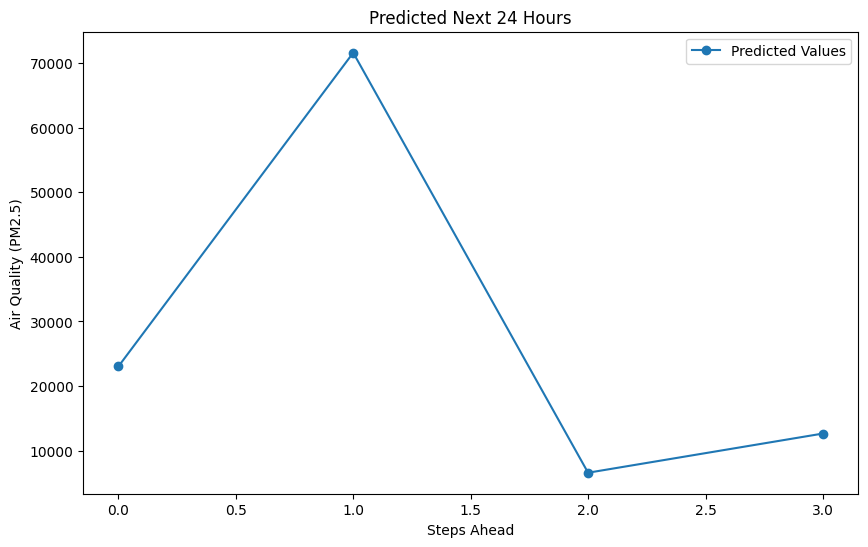

In [ ]:
import torch
import torch.nn as nn
from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from fastai.callback.tracker import EarlyStoppingCallback
from google.colab import drive

class PatchTST(nn.Module):
    def __init__(self,
                 c_in,
                 c_out,
                 seq_len,
                 pred_dim=None,
                 n_layers=2,
                 n_heads=8,
                 d_model=512,
                 d_ff=2048,
                 dropout=0.05,
                 attn_dropout=0.,
                 patch_len=16,
                 stride=8,
                 padding_patch=True,
                 revin=True,
                 affine=False,
                 individual=False,
                 subtract_last=False,
                 decomposition=False,
                 kernel_size=25,
                 activation="gelu",
                 norm='BatchNorm',
                 pre_norm=False,
                 res_attention=True,
                 store_attn=False,
                 ):
        super().__init__()

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.n_patches = (seq_len // patch_len) + (1 if seq_len % patch_len else 0)

        self.patch_embedding = nn.Linear(patch_len, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.n_patches + 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                                                   dropout=dropout, activation=activation)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.output_layer = nn.Linear(d_model, c_out)

    def forward(self, x):
        batch_size = x.size(0)
        if self.padding_patch:
            if x.shape[-1] % self.patch_len != 0:
                pad_len = self.patch_len - x.shape[-1] % self.patch_len
                x = torch.cat([x, torch.zeros(batch_size, x.shape[1], pad_len, device=x.device)], dim=-1)

        patches = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        patches = patches.reshape(batch_size, patches.shape[1], -1, self.patch_len)
        patches = patches.permute(0, 2, 1, 3)
        patches = patches.reshape(batch_size, patches.shape[1], -1)

        embeddings = self.patch_embedding(patches)
        embeddings = embeddings + self.position_embedding[:, :embeddings.shape[1], :]

        embeddings = embeddings.permute(1, 0, 2)
        encoded_output = self.transformer_encoder(embeddings)

        output = encoded_output[-1]
        output = self.output_layer(output)

        return output

def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start'])
df = df[['Start', 'Value']].sort_values(by='Start')
df.set_index('Start', inplace=True)
df['Value'] = df['Value'].astype(float)
df.dropna(subset=['Value'], inplace=True)
df['category'] = df['Value'].apply(get_AQI_bucket)
category_mapping = {'Good': 1, 'Satisfactory': 2, 'Moderate': 3, 'Poor': 4, 'Very Poor': 5, 'Severe': 6}
df['label'] = df['category'].map(category_mapping)
df_resampled = df[['Value']].resample('6H').mean().interpolate()
scaler = MinMaxScaler()
df_resampled['Value'] = scaler.fit_transform(df_resampled[['Value']])
values = df_resampled['Value'].values
sequence_length = 24
forecast_steps = 4
X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)
train_size = int(len(X) * 0.8)
valid_size = int(len(X) * 0.1)
splits = (
    list(range(train_size)),
    list(range(train_size, train_size + valid_size)),
    list(range(train_size + valid_size, len(X)))
)
tfms = [None, TSForecasting()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)
model = PatchTST(
    c_in=1,
    c_out=forecast_steps,
    seq_len=sequence_length,
    n_layers=2,
    n_heads=8,
    d_model=512,
    d_ff=2048,
    dropout=0.05,
    patch_len=16,
    stride=8
)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae], cbs=[early_stop_cb])
learn.fit_one_cycle(10, lr_max=1e-3)
train_mae, train_acc = learn.validate(ds_idx=0)
valid_mae, valid_acc = learn.validate(ds_idx=1)
test_mae, test_acc = learn.validate(ds_idx=2)
print(f"Train MAE: {train_mae:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation MAE: {valid_mae:.4f}, Validation Accuracy: {valid_acc:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test Accuracy: {test_acc:.4f}")
last_seq = values[-sequence_length:].reshape(1, sequence_length)
last_seq = torch.tensor(last_seq).unsqueeze(1).float()
preds = learn.get_X_preds(last_seq)[0].numpy()
preds = np.clip(preds, 0, 1)
preds = scaler.inverse_transform(preds)
forecast_with_categories = []
for p in preds.flatten():
    category = get_AQI_bucket(p)
    forecast_with_categories.append(f"{p:.2f}: {category}")
print(f"Predicted next {forecast_steps * 6} hours (4 steps): {', '.join(forecast_with_categories)}")
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps * 6} Hours")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()
